
## Business Problem 

Universal bank issues loan to its customers based on customer information known as features. Now the bank wants to build a  model which can predict if a customer is eligible to issue loan or not. The ROI of this transformation from legacy based decisioning to AI based decisioning is the fast disbursal to the loan along with enhancing the better customer reach.
  

In [1]:
#Importing the libararies
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import sys
import missingno as msno
import pandas_profiling
import scipy.stats as stats
import imblearn
import shap 

from matplotlib import pyplot as plt
from matplotlib import cm as cm

from scipy.stats import chi2_contingency
from scipy.stats import skew
from scipy.stats import kurtosis

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve , auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
bank_data = 'UniversalBank.csv'  # File containing bank data

In [3]:
bank_df = pd.read_csv(bank_data,engine='c')  # engine = 'c' is used for backend C based computation

In [4]:
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [5]:
def basic_info(df):
    '''
    Function to get basic information of the data set
    input: dataframe
    output: No of rows and columns    
    '''
    data_dim = [
        ['Summary Statistics for: ', 'Bank Data'],
        ['Number of Rows: ', bank_df.shape[0]],
        ['Number of Columns: ', bank_df.shape[1]]
        ]
    temp_bank_df_df = pd.DataFrame(data_dim)
    return temp_bank_df_df.head()


basic_info(bank_df)

,0,1
0,Summary Statistics for:,Bank Data
1,Number of Rows:,5000
2,Number of Columns:,14


### Basic Statistics
> Lets try and understand the basic summary statistics of data.

In [6]:
def data_statistics(df):
    '''
    Basic Statistics information of bank data
    input: bank df
    output: Information of mean, percentiles, Null values in columns etc.    
    '''
    df_des = df.describe().T
    NA_Col = pd.DataFrame(df.isnull().sum(), columns=['NA']) 
    stat_df = pd.concat([df_des,NA_Col], axis=1)
    #stat_df = stat_df.reindex(df_des.index)
    return stat_df


data_statistics(bank_df)

,count,mean,std,min,25%,50%,75%,max,NA
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0,0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0,0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0,0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0,0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0,0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0,0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0,0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0,0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0,0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0,0


### Remove unwanted cols
> Remove Constant and Duplicate Columns.

> From the statistics summary we observe that 'Experience' columns has some negative values so we will deal with it in feature engineering phase.
> Also 'ID' and 'ZIP Code' columns will not add value to features, hence we can also delete them 

In [7]:
def remove_cols(df):
    '''
    Check and remove the unwanted columns
    input: df
    output: cleaned dataframe    
    '''
    Constant_Values = df.columns[df.eq(df.iloc[0]).all()].tolist()
    Duplicate_Columns = df.columns[df.T.duplicated(keep='first').T]  # Only report second column as duplicate
    
    df = df.drop(Constant_Values, axis=1)
    df = df.drop(Duplicate_Columns, axis=1)
    df = df.drop(['ID', 'ZIP Code'], axis = 1)
    return df

bank_df = remove_cols(bank_df)

## Missing Values
> Function to find the missing values
> - There was no missing values in bank data

In [8]:

def missing_values_table(df):
    '''
    Check the missing values in the data columns
    input: df
    output: Dataframe of columns and their missing value percent    
    '''
    missing_val = df.isnull().sum()
    missing_val_percent = 100 * df.isnull().sum() / len(df)

    
    mis_val_table = pd.concat([missing_val, missing_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    return mis_val_table_ren_columns

missing_values_train = print(missing_values_table(bank_df))

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


## EDA



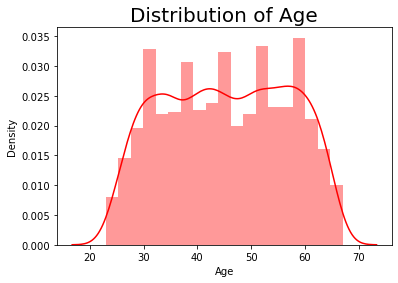

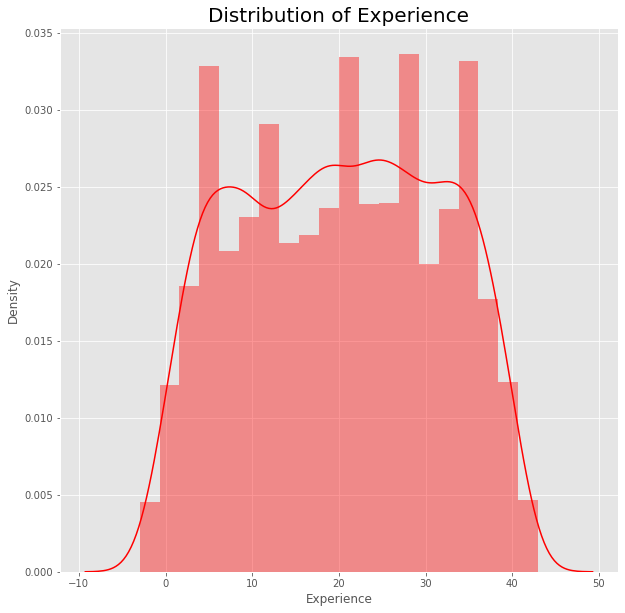

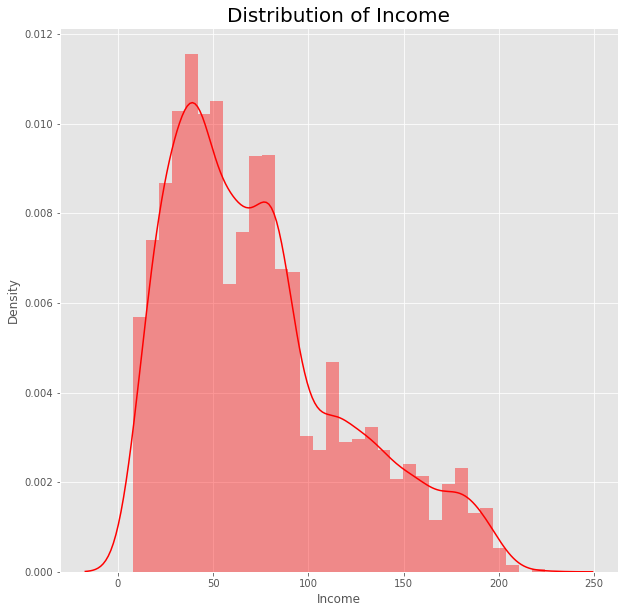

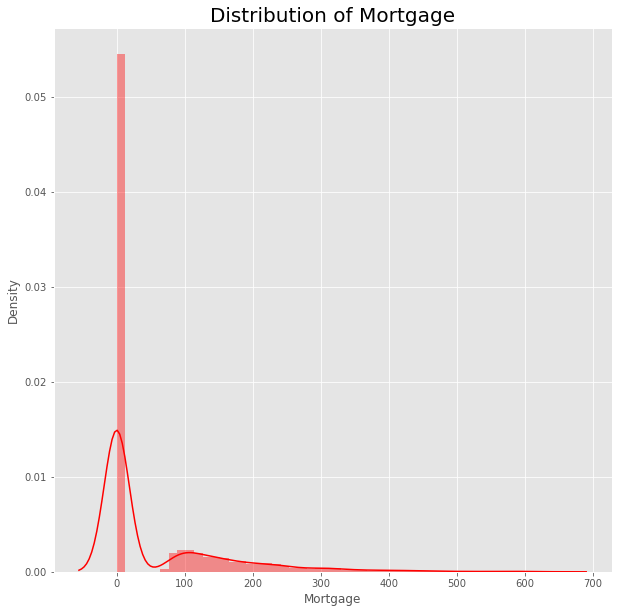

In [9]:
# Check the distribution of columns
def plot_dist(df, x:str):
    '''
    Check the distributions in the data columns
    input: df, column name
    output: distribution plots    
    '''
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = (10,10)
    sns.distplot(df[x], color = 'red')
    plt.title("Distribution of {}".format(x), fontsize = 20)
    plt.show()

data_cols = ['Age', 'Experience', 'Income', 'Mortgage']
for col in data_cols:
    plot_dist(bank_df, col )


From the above distribution plot we found that Income and Mortgage columns are sweked and have kurtosis, so we have to take the lograthim of these columns in the feature engineering section

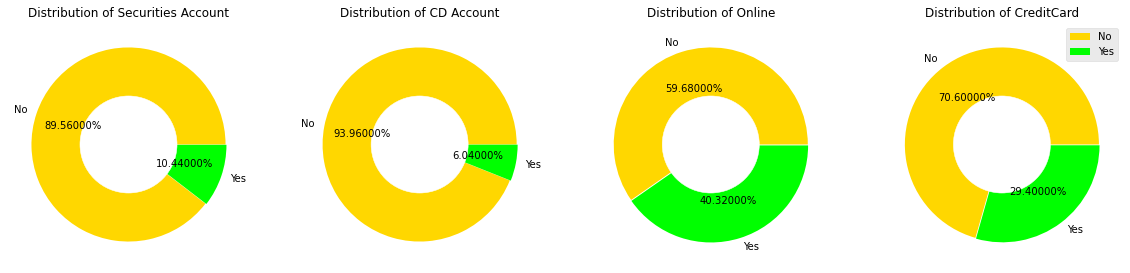

In [10]:
# plotting a donut chart for visualizing 'Securities Account','CD Account','Online','CreditCard'

fig, ax = plt.subplots(1,5,figsize=(20,20))
cols = ['Securities Account','CD Account','Online','CreditCard']

for i,column in enumerate(cols):
    plt.subplot(1,4,i+1)
    count = bank_df[column].value_counts()
    color = ['gold', 'lime']
    label = "No", "Yes"
    explode = [0, 0.01]

    donut_circle = plt.Circle((0, 0), 0.5, color = 'white')

    plt.rcParams['figure.figsize'] = (25, 25)
    plt.pie(count, colors = color, labels = label, shadow = False, explode = explode, autopct = '%.5f%%')
    plt.title('Distribution of {}'.format(column), fontsize = 12)
    p = plt.gcf()
    p.gca().add_artist(donut_circle)
plt.legend()
plt.show()


The above donut chart shows distribution of securities account, CD account, online, and credit card; we observe that these are categorical values so encoding techniques is required to apply in feature emgineering phase.

#### Correlation between Variables

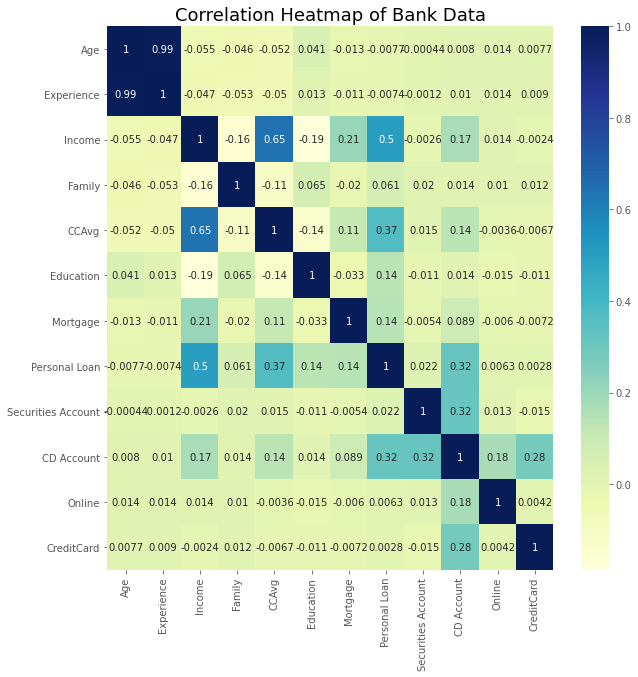

In [11]:
plt.rcParams['figure.figsize'] = (10,10)
plt.style.use('ggplot')

sns.heatmap(bank_df.corr(), annot = True, cmap = 'YlGnBu')
plt.title('Correlation Heatmap of Bank Data', fontsize = 18)
plt.show()

Age and Experience columns are highly correlated so we have to either remove one or have to diagnosis at the time of feature engineering

### Feature Engineering

In [12]:
# Convert some columns to categorical columns
def num_to_cat_col(df, column:str):
    df[column] = df[column].astype('object')

bank_cat_cols = ['Securities Account','CD Account','Online','CreditCard']

for col in bank_cat_cols:
    num_to_cat_col(bank_df, col)


In [13]:
# Convert few columns to logarithm + Normalization transformation to make them normal distributed columns

def norm_transform(column):
    upper_limit = column.max()
    lower_limit = column.min()
    col_norm = (column - lower_limit)/(upper_limit-lower_limit)
    return col_norm

bank_df['Income'] = np.log(bank_df.Income + 1)
bank_df['Income'] = norm_transform(bank_df['Income'])

bank_df['Mortgage'] = np.log(bank_df.Mortgage + 1)
bank_df['Mortgage'] = norm_transform(bank_df['Mortgage'])


##### Handling of correlation between Age and Experience
From the statistics summary of data we observed that Experience columns has some negative values, also we checked the correlation between Age and Experience and found that they are highly corrleated hence dropping the Experience column

In [14]:
# Correlation and dropping the redundant column
print(bank_df['Age'].corr(bank_df['Experience']))
bank_df = bank_df.drop(['Experience'], axis=1)

0.994214856968332


### Model Building
> - Random forest classifieris used
> - Hyperparameter tunning is performed using Random Search CV

In [15]:
label = bank_df['Personal Loan'] # Label
features = bank_df.drop('Personal Loan',axis=1) # Data features

print('Shape of X: {}'.format(features.shape))
print('Shape of y: {}'.format(label.shape))
print(label.value_counts())

Shape of X: (5000, 10)
Shape of y: (5000,)
0    4520
1     480
Name: Personal Loan, dtype: int64


In [16]:
features = pd.get_dummies(features, drop_first=True)   # One Hot Encoding (OHE) for Categorical Features

#### Handling the Imbalanced Data
Since the data is imbalanced so we need to apply oversampling to make it balance using smote 

In [17]:
train_x, test_x, train_y, test_y = train_test_split(features, label, test_size=.25, random_state=23)

samp = SMOTE()
train_x_samp, train_y_samp = samp.fit_sample(train_x, train_y.ravel())

In [18]:
# Get the hyperparameter for Random Forest

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ['balanced']
criterion =  ['gini', 'entropy']                                           

# find best set of features from random search using random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion,
               'class_weight': class_weight}

print(param_grid)

{'n_estimators': [100, 166, 233, 300, 366, 433, 500, 566, 633, 700], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced']}


In [19]:

def rf_clf(train_x, train_y):
    
    classifier= RandomForestClassifier(random_state = 42) # Random Forest
    
   
    grid_search = RandomizedSearchCV(estimator = classifier, param_distributions = param_grid, n_iter = 100, scoring='accuracy', return_train_score=True, cv = 2, n_jobs = -1, verbose = 2)
    grid_search.fit(train_x, train_y)
    
    print("The best parameters are %s with a score of %0.2f" % (grid_search.best_params_, grid_search.best_score_))
    
    classfier_model = grid_search.best_estimator_
    return classfier_model


classfier_model = rf_clf(train_x_samp, train_y_samp.ravel())

classfier_model.fit(train_x_samp, train_y_samp.ravel())
predictions = classfier_model.predict(test_x)



Fitting 2 folds for each of 100 candidates, totalling 200 fits
The best parameters are {'n_estimators': 566, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False} with a score of 0.99


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1114
           1       0.92      0.89      0.91       136

    accuracy                           0.98      1250
   macro avg       0.96      0.94      0.95      1250
weighted avg       0.98      0.98      0.98      1250



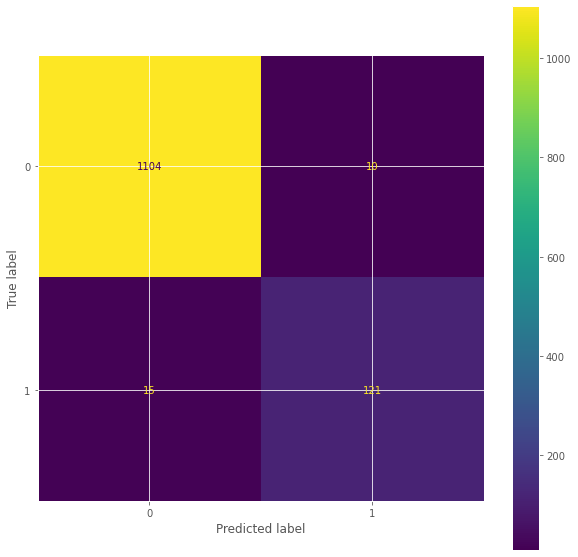

In [20]:
#Confusion Matrix
model_report = classification_report(test_y, predictions)
print(model_report)

plot_confusion_matrix(classfier_model, test_x, test_y)

### Explain AI

Intrepreting the model is important as it will impart trust in customers for the Bank as they get to know the reason of which features are used for their Loan decision: Approved/Disapproved.

Thus it can be observed that 'Income', 'CCAvg' and 'Education' are the most important features while 'Age' & 'Securities Account' being the least.

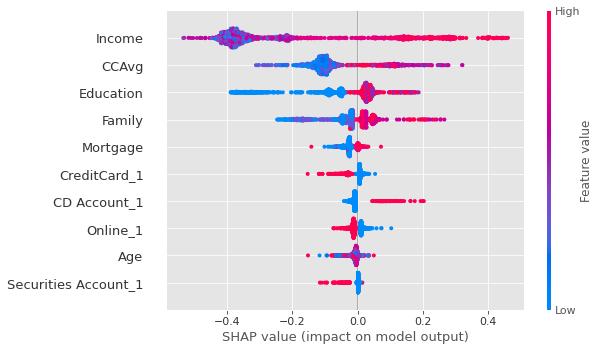

In [21]:
explainer = shap.TreeExplainer(classfier_model)
shap_values = explainer.shap_values(test_x)

shap.summary_plot(shap_values[1], test_x)